In [1]:
from ml_core import *

generate_frames_params = {
    'rotation': True,
    'interpolation': True,
    'concat_previous_targets': False,
    'component': 'all',
    'frame_length': 2,
    }
make_graph_params = {
    'return_nodal_pos': False,
    'maxK': 1.0,
    'flatten': False
    }


# Use seaborn style for a more modern look
sns.set_style("whitegrid", {'axes.grid': False})

graph_batch_size = {'test': 1, 'valid': 1, 'train': 100}
num_equally_spaced_frames = 10

left_pad = False
flatten = 'time' # can be 'all', 'time', or None.

ds_normalized, ds_one_graph, preprocess_func = preprocessor_init(
    left_pad,
    generate_frames_params,
    num_equally_spaced_frames,
    graph_batch_size,
    make_graph_params,
    )

# normalization from https://arxiv.org/pdf/2101.08482.pdf
make_graph_func = lambda sample: make_graph(
    preprocess_func['train'](sample), **make_graph_params
    )
ds = ds_normalized['train'].map(make_graph_func, num_parallel_calls=auto)

In [ ]:
lambda_dict = get_lambdas(ds, num_iterations=10)
lambda_dict['edge_features'] = None

100%|██████████| 10/10 [01:22<00:00,  8.28s/it]


In [ ]:
num_iterations = 10

edge_norm_stats = get_min_max_stats(ds, keys = ['edge_features'], num_iterations=num_iterations)
with_norm_stats = get_min_max_stats(ds, num_iterations=num_iterations)
with_yeo_stats = get_min_max_stats(ds, num_iterations=num_iterations, lambda_dict=lambda_dict)
with_cbrt_stats = get_min_max_stats(ds, num_iterations=num_iterations, cbrt=True)
with_transform_stats = get_min_max_stats(ds, num_iterations=num_iterations, lambda_dict=lambda_dict, cbrt=True)


for k in with_yeo_stats:
    with_yeo_stats[k].update(edge_norm_stats[k])
    with_cbrt_stats[k].update(edge_norm_stats[k])
    with_norm_stats[k].update(edge_norm_stats[k])
    with_transform_stats[k].update(edge_norm_stats[k])

100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


In [ ]:
full_none_dict = {k: None for k in ['node_features', 'targets', 'edge_features']}

with_yeo_stats['lambda_dict'] = lambda_dict
with_yeo_stats['cbrt'] = with_yeo_stats['mins'] = with_yeo_stats['maxs'] = full_none_dict

with_cbrt_stats['cbrt'] = {'node_features': True, 'targets': True, 'edge_features': None}
with_cbrt_stats['lambda_dict'] =  with_cbrt_stats['mins'] = with_cbrt_stats['maxs'] = full_none_dict

with_norm_stats['cbrt'] = with_norm_stats['lambda_dict'] = full_none_dict

with_transform_stats['lambda_dict'] = lambda_dict
with_transform_stats['cbrt'] = {'node_features': True, 'targets': True, 'edge_features': None}

In [ ]:
save_transform_stats('with_yeo_stats', with_yeo_stats)
save_transform_stats('with_cbrt_stats', with_cbrt_stats)
save_transform_stats('with_norm_stats', with_norm_stats)
save_transform_stats('with_transform_stats', with_transform_stats)

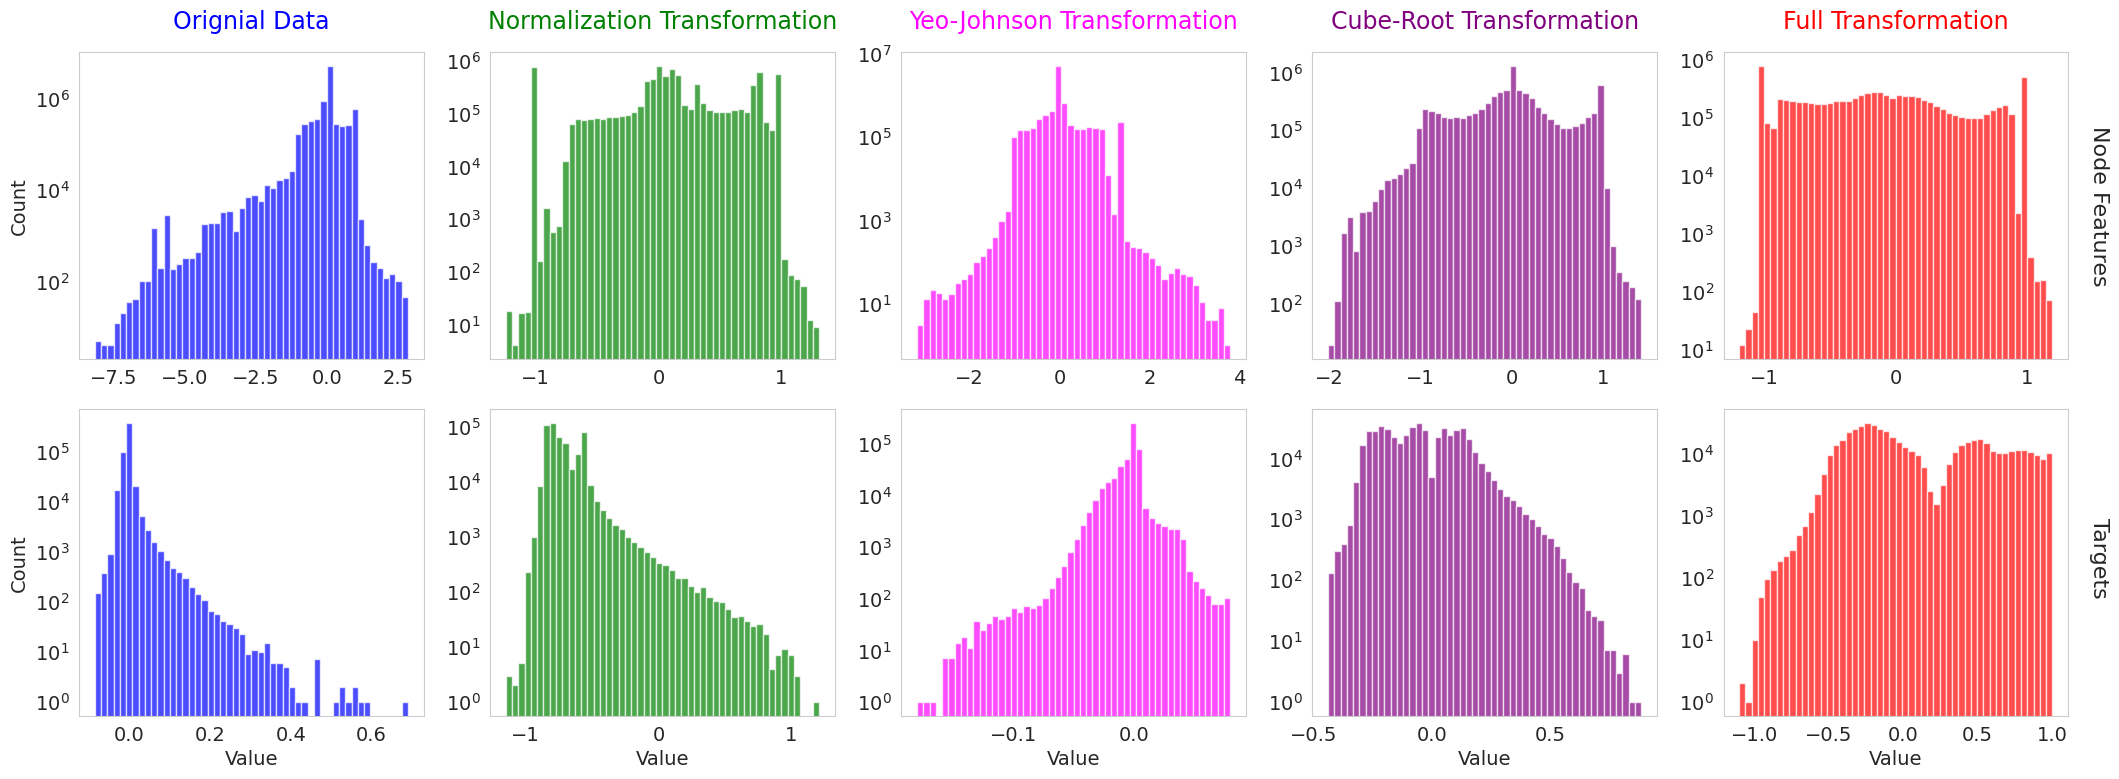

In [ ]:
for sample in ds.take(1): pass

del sample['senders'], sample['receivers']
edge_features = sample.pop('edge_features')

with_full_transformation = transform(sample, **with_transform_stats)
with_yeo = transform(sample, **with_yeo_stats)
with_cbrt = transform(sample, **with_cbrt_stats)
with_norm = transform(sample, **with_norm_stats)

data_dicts = [sample, with_norm, with_yeo, with_cbrt, with_full_transformation]
fig, axs = plt.subplots(2, 5, figsize=(21, 8))
keys = sample.keys()

titles = ["Orignial Data", "Normalization Transformation", "Yeo-Johnson Transformation", "Cube-Root Transformation", "Full Transformation"]
colors = ['blue', 'green', 'magenta', 'purple', 'red']

text_pos = [0.73, 0.29]

for row_idx, key in enumerate(keys):
    formatted_key = ' '.join([word.capitalize() for word in key.split('_')])

    fig.text(1.0, text_pos[row_idx], formatted_key, va='center', rotation=-90, fontsize=16)
    data_list = [data_dicts[i][key] for i in range(5)]
    for col_idx, (data, title, color) in enumerate(zip(data_list, titles, colors)):
        flat_data = tf.reshape(data, [-1]).numpy()
        axs[row_idx, col_idx].hist(flat_data, bins=50, color=color, alpha=0.7)
        axs[row_idx, col_idx].set_yscale('log')

        if row_idx == 0:
            axs[row_idx, col_idx].set_title(title, color=color, y=1.05)
        if row_idx == len(keys) - 1:  # Only for the last row
            axs[row_idx, col_idx].set_xlabel("Value", fontsize=14)
        if col_idx == 0:  # Only for the first column
            axs[row_idx, col_idx].set_ylabel("Count", fontsize=14)

plt.tight_layout()
plt.savefig('transforamtion.pdf', format='pdf', bbox_inches='tight')
plt.show()